In [1]:
import sklearn as skl
import sys
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
import math
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import janitor
import cairo
import random
import re
import collections
import networkx as nx
from plotly.subplots import make_subplots
from sklearn.cluster import KMeans
from kmodes.kprototypes import KPrototypes
from collections import namedtuple
from random import randint

In [2]:
np.set_printoptions(threshold=sys.maxsize)

In [3]:
Point = collections.namedtuple('Point', 'x y')

In [4]:
df = pd.read_excel('DataVisualizationV5.xlsx', sheet_name='QualitySheet')
pf = pd.read_excel('DataVisualizationV5.xlsx', sheet_name='PhaseSheet')
ss = pd.read_excel('DataVisualizationV5.xlsx', sheet_name='SizeSpec')
ds = pd.read_excel('DataVisualizationV5.xlsx', sheet_name='SequenceSheet')
ess = pd.read_excel('DataVisualizationV5.xlsx', sheet_name='EntireSequenceSheet')

In [5]:
jitteredDf = df.copy()
sample = df.copy()
sample = sample.drop(columns=['Quality'])

In [6]:
sample = sample.columns.values.tolist()

In [7]:
for f in sample:
    jitteredDf.jitter(
        column_name=f,
        dest_column_name=f,
        scale=0.5,
        clip=None,
        random_state=None
    )

In [8]:
meltedPhases = pf.melt('Procedures', var_name='Instruments')

In [9]:
fig = px.bar(meltedPhases, x="Instruments", y="value",
             facet_col="Procedures",
            facet_col_wrap=2)
fig.update_yaxes(range=[0,1])
fig.update_yaxes(nticks=2)
fig.show()

In [10]:
meltedDf = df.melt('Quality', var_name='Instruments')

In [11]:
jitteredMelt = jitteredDf.melt('Quality', var_name='Instruments')

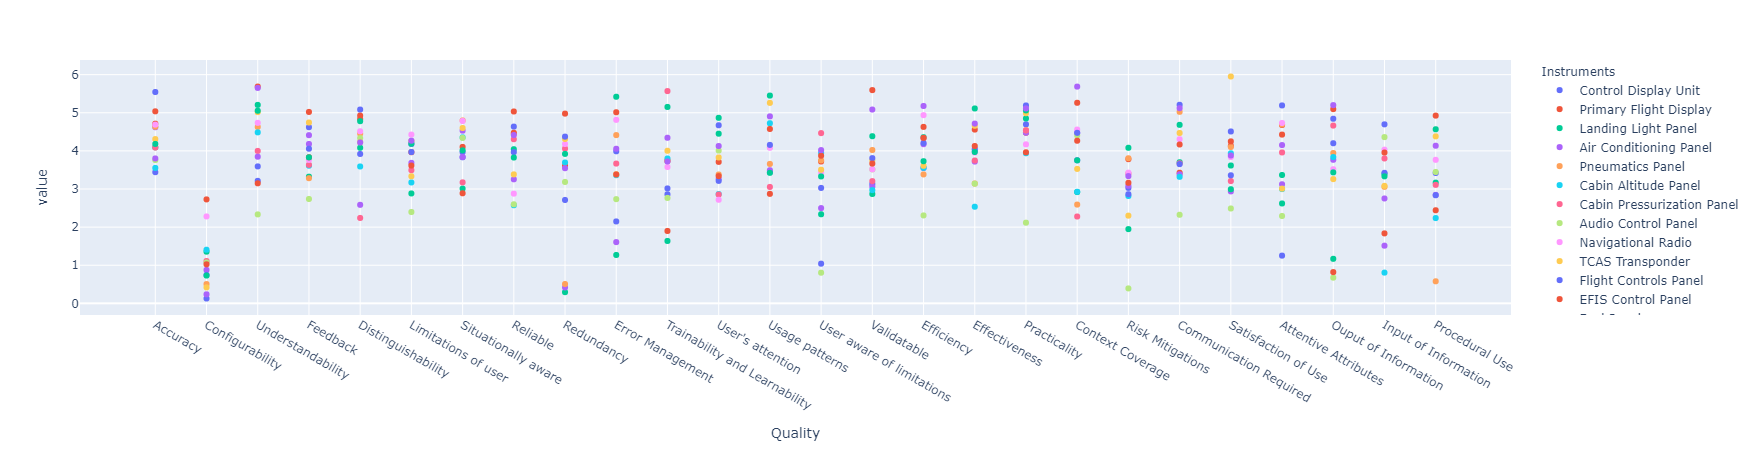

In [12]:
fig = px.scatter(jitteredMelt, x="Quality", y="value", color="Instruments")
fig.show()

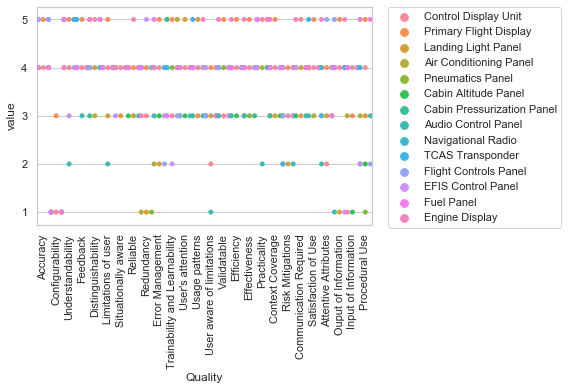

In [13]:
y = [1, 2, 3, 4, 5]
yint = range(min(y), math.ceil(max(y))+1)
sns.set(style="whitegrid", color_codes=True)
g = sns.swarmplot(x="Quality", y="value", hue='Instruments', data=meltedDf)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.rcParams['figure.figsize'] = [25, 25]
plt.yticks(yint)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [14]:
def getColPalette():
    hex_colors_dic = {}
    rgb_colors_dic = {}
    hex_colors_only = []
    for name, hex in mpl.colors.cnames.items():
        hex_colors_only.append(hex)
        hex_colors_dic[name] = hex
        rgb_colors_dic[name] = mpl.colors.to_rgb(hex)
    return random.choice(hex_colors_only)

In [15]:
def printRadarPlots(dataDF, colName):
    ## Since we are using DF which is un-edited at this point in the program, I am going to assume that the Quality column is in the dataFrame
    fig = make_subplots(rows=1, cols=1, specs=[[{"type": "polar"}]])
    fig.add_trace(go.Scatterpolar(
        name=colName,
        r=dataDF[colName],
        theta=dataDF['Quality'],
        marker_color = getColPalette(),
        fill='toself'
        ), 1, 1)
    fig.update_layout(height=500, width=500, title_text=colName)
    fig.show()

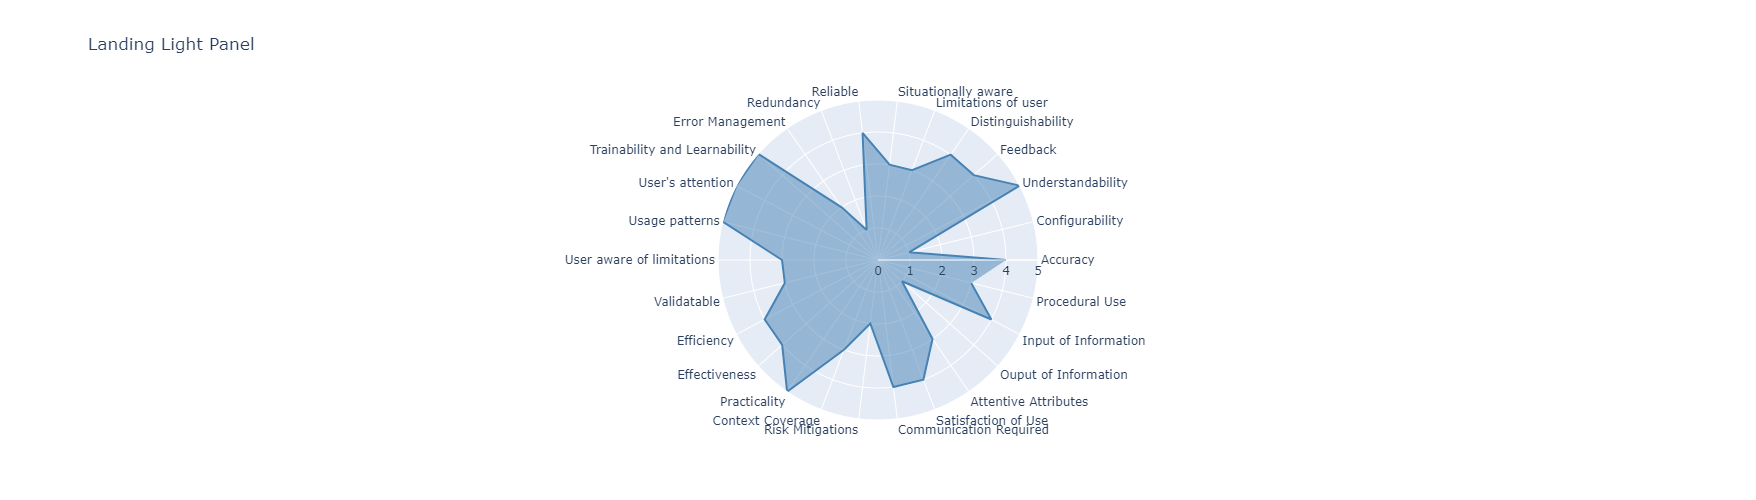

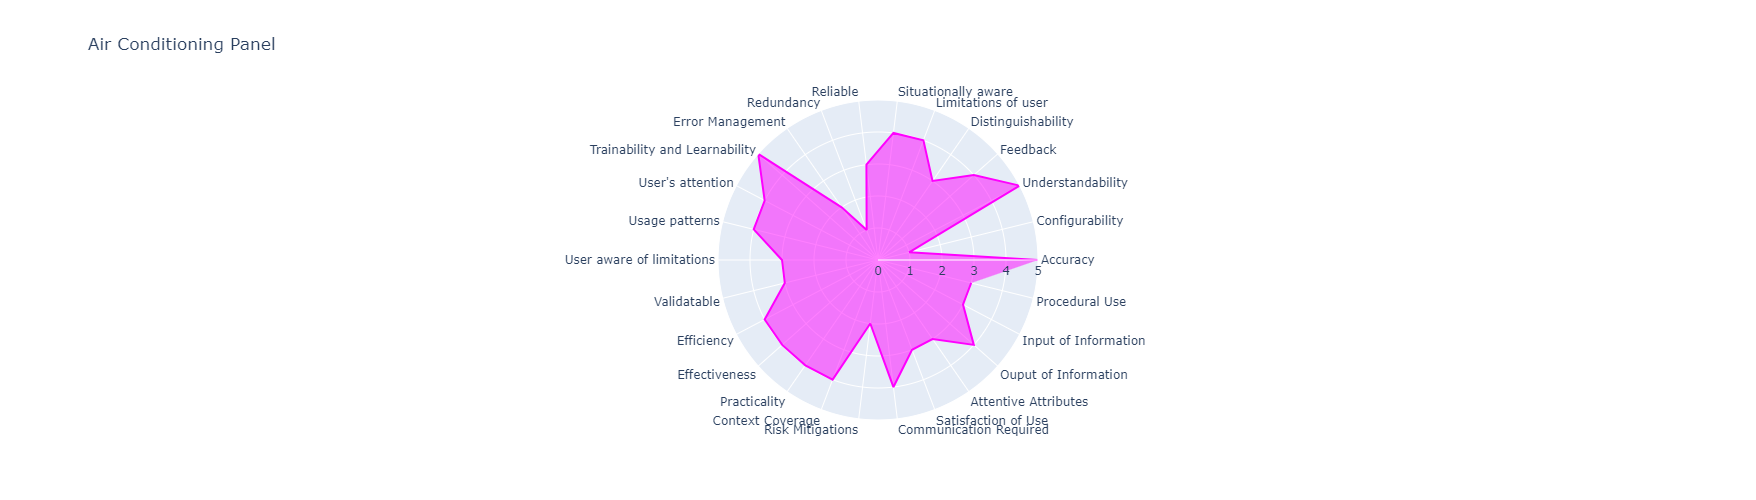

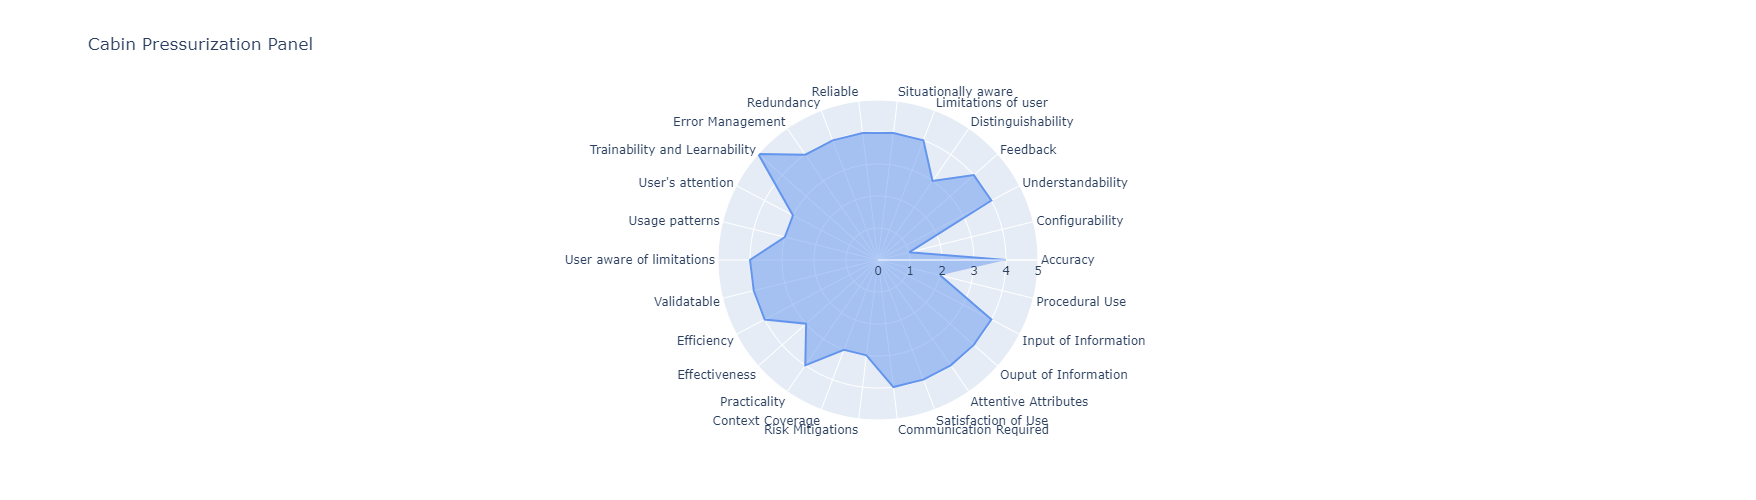

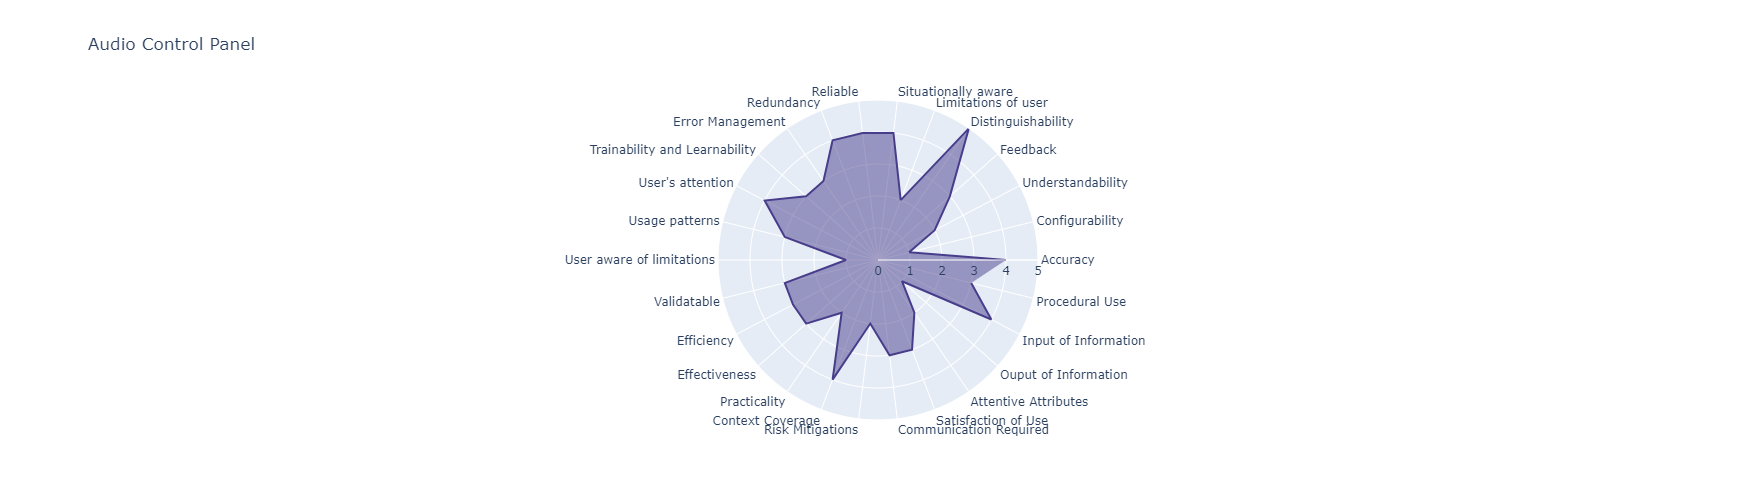

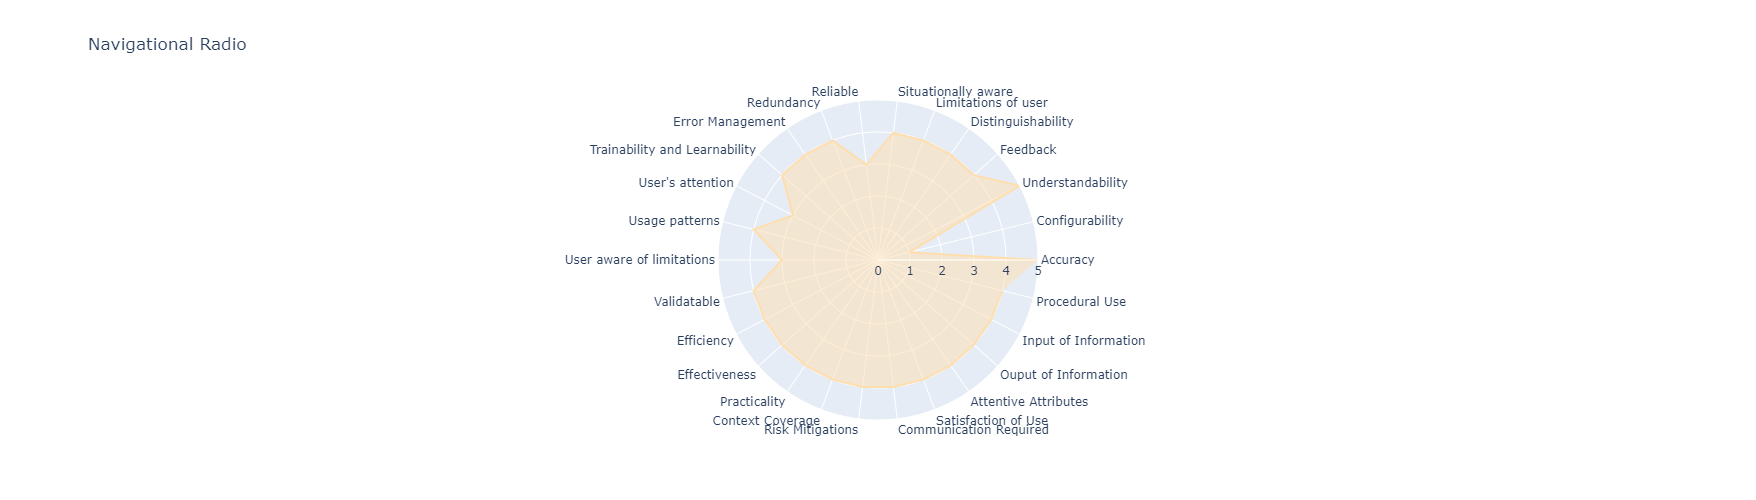

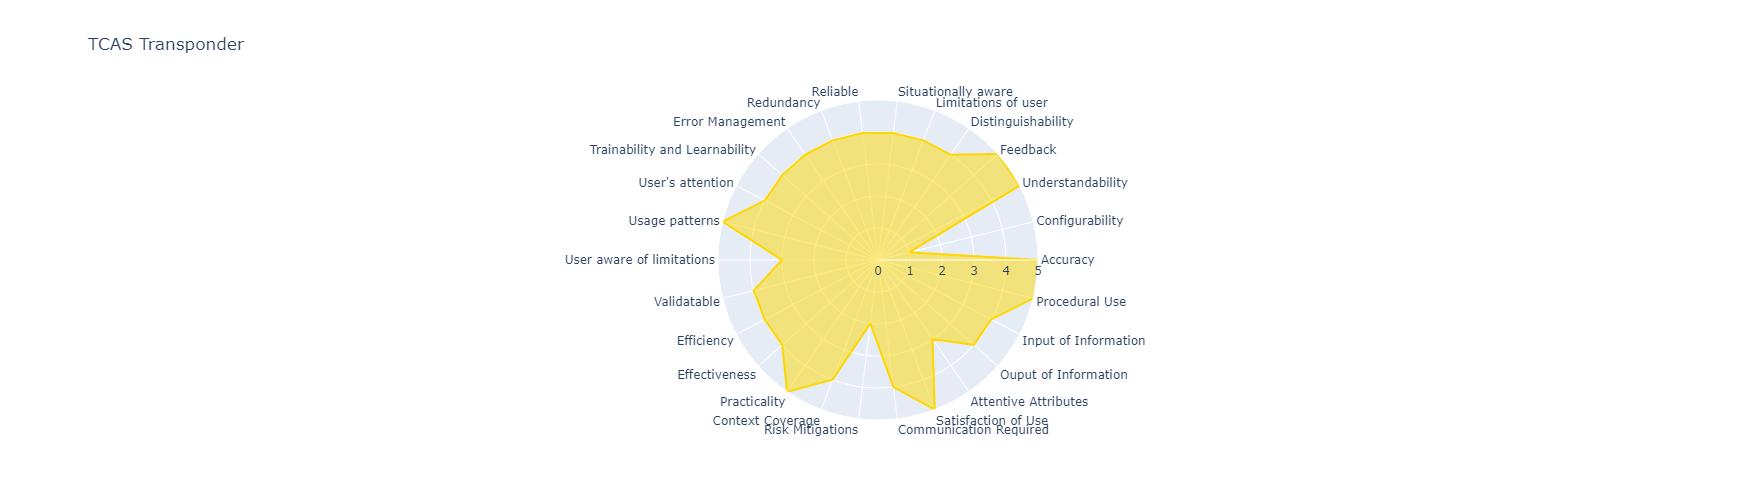

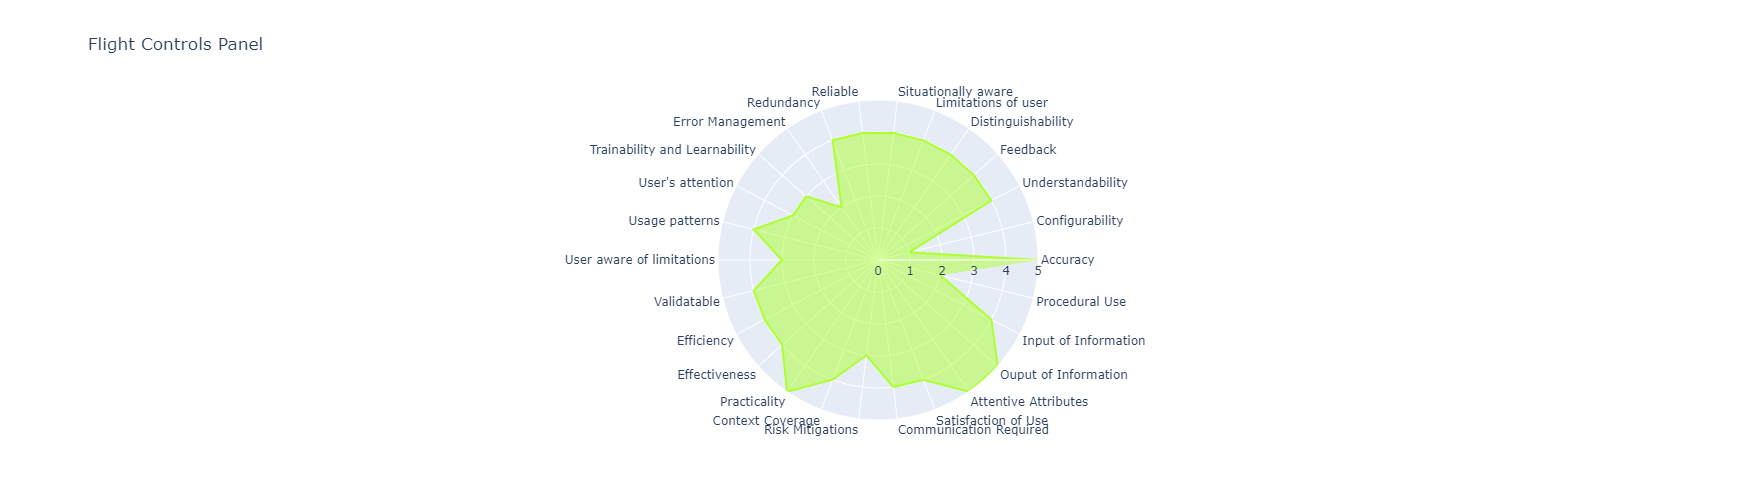

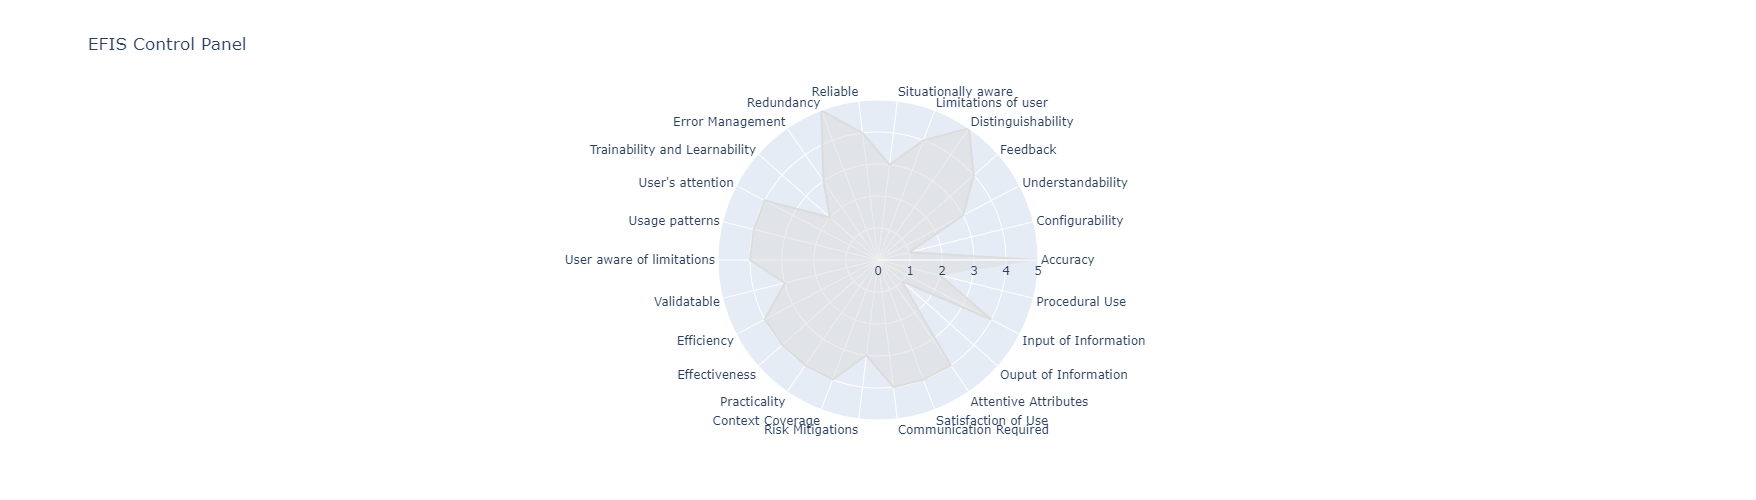

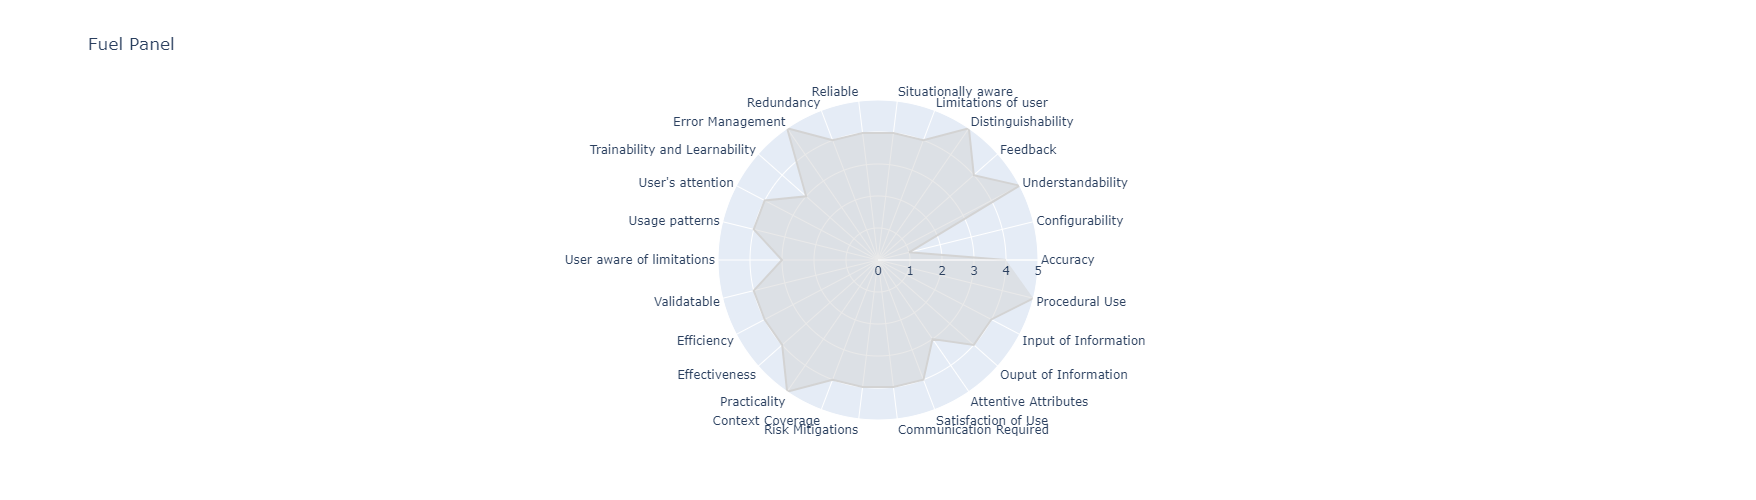

In [16]:
for col in df.columns:
    if col != 'Quality':
        printRadarPlots(df, col)

In [17]:
X = jitteredDf.iloc[:,1:].values

In [18]:
## Elbow method
Error =[]
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i).fit(X)
    kmeans.fit(X)
    Error.append(kmeans.inertia_)
plt.plot(range(1, 11), Error)
plt.title('Elbow method')
plt.xlabel('No of clusters')
plt.ylabel('Error')
plt.show()

In [19]:
kPro = KPrototypes(n_clusters=3, max_iter=600, n_init=50, init='Cao')

In [20]:
kResult = kPro.fit_predict(jitteredDf, categorical=[0])

In [21]:
jitteredDf['Clusters'] = kResult

In [22]:
jitteredMelt2 = pd.melt(jitteredDf, id_vars=['Quality', 'Clusters'], var_name='Instruments')

In [23]:
fig = px.scatter(jitteredMelt2, x="Quality", y="value", color="Clusters")
fig.show()

In [24]:
def drawDetailedUndirectedGraphs(ds):
    for index in ds.index.values:
        tempGraph = nx.Graph()
        frames = ds.iloc[index]
        frames = frames.drop_duplicates(keep=False)
        tempGraph.add_nodes_from(frames.index.values)
        size = getSize(frames)
        lastUsed = getFirst(frames)
        for i in range(1, size+1):
            iterator = frames[frames == i].index.values
            if len(iterator) == 0:
                res = findIndexUsingNum(frames, i)
                tempGraph.add_edge(lastUsed, res, weight=1)
                lastUsed = res
            else:
                tempGraph.add_edge(lastUsed, iterator[0], weight=1)
                lastUsed = iterator[0]
        plt.rcParams['figure.figsize'] = [5, 5]
        labels = nx.get_edge_attributes(tempGraph,'weight')
        nx.draw_networkx_edge_labels(tempGraph,pos=nx.circular_layout(tempGraph),edge_labels=labels)
        nx.draw_circular(tempGraph, with_labels=True)
        plt.draw()
        plt.show()

In [25]:
def drawDetailedDirectedGraphs(ds):
    for index in ds.index.values:
        tempGraph = nx.DiGraph()
        frames = ds.iloc[index]
        frames = frames.drop_duplicates(keep=False)
        tempGraph.add_nodes_from(frames.index.values)
        size = getSize(frames)
        lastUsed = getFirst(frames)
        for i in range(1, size+1):
            iterator = frames[frames == i].index.values
            if len(iterator) == 0:
                res = findIndexUsingNum(frames, i)
                tempGraph.add_edge(lastUsed, res, weight=1)
                lastUsed = res
            else:
                tempGraph.add_edge(lastUsed, iterator[0], weight=1)
                lastUsed = iterator[0]
        plt.rcParams['figure.figsize'] = [5, 5]
        nx.draw_circular(tempGraph, with_labels=True)
        labels = nx.get_edge_attributes(tempGraph,'weight')
        nx.draw_networkx_edge_labels(tempGraph,pos=nx.circular_layout(tempGraph),edge_labels=labels)
        plt.draw()
        plt.show()

In [26]:
def drawFullDetailedUndirectedGraphs(ds):
    tempGraph = nx.Graph()
    tempGraph.add_nodes_from(ds.columns)
    for index in ds.index.values:
        frames = ds.iloc[index]
        frames = frames.drop_duplicates(keep=False)
        size = getSize(frames)
        lastUsed = getFirst(frames)
        for i in range(1, size+1):
            iterator = frames[frames == i].index.values
            if len(iterator) == 0:
                res = findIndexUsingNum(frames, i)
                tempGraph.add_edge(lastUsed, res, weight=1)
                lastUsed = res
            else:
                tempGraph.add_edge(lastUsed, iterator[0], weight=1)
                lastUsed = iterator[0]
    plt.rcParams['figure.figsize'] = [15, 15]
    nx.draw_circular(tempGraph, with_labels=True)
    labels = nx.get_edge_attributes(tempGraph,'weight')
    nx.draw_networkx_edge_labels(tempGraph,pos=nx.circular_layout(tempGraph),edge_labels=labels)
    plt.draw()
    plt.show()


In [27]:
def drawFullDetailedDirectedGraphs(ds):
    tempGraph = nx.DiGraph()
    tempGraph.add_nodes_from(ds.columns)
    for index in ds.index.values:
        frames = ds.iloc[index]
        frames = frames.drop_duplicates(keep=False)
        size = getSize(frames)
        lastUsed = getFirst(frames)
        for i in range(1, size+1):
            iterator = frames[frames == i].index.values
            if len(iterator) == 0:
                res = findIndexUsingNum(frames, i)
                tempGraph.add_edge(lastUsed, res, weight=1)
                lastUsed = res
            else:
                tempGraph.add_edge(lastUsed, iterator[0], weight=1)
                lastUsed = iterator[0]
    plt.rcParams['figure.figsize'] = [15, 15]
    nx.draw_circular(tempGraph, with_labels=True)
    labels = nx.get_edge_attributes(tempGraph,'weight')
    nx.draw_networkx_edge_labels(tempGraph,pos=nx.circular_layout(tempGraph),edge_labels=labels)
    plt.draw()
    plt.show()

In [28]:
def getFirst(frames):
    iterator = frames[frames == 1].index.values
    if len(iterator) == 0:
        return findIndexUsingNum(frames, 1)
    else:
        return iterator[0]

In [29]:
def getSize(frame):
    size = frame.size
    for f in frame:
        if(type(f) == np.str):
            for c in f:
                if(c == ','):
                    size+=1
    return size

In [30]:
def comCheck(dataframe):
    comCount = 0
    for row in dataframe.index.values:
        rowFrame = dataframe.iloc[row]
        for f in rowFrame:
            if(type(f) == np.str):
                for c in f:
                    if(c == ','):
                        comCount+=1
    return comCount

In [31]:
def findIndexUsingNum(frames, number):
    for frame in frames:
        if(type(frame) == np.str):
            nums = re.findall('\d+', frame)
            nums = list(map(int, nums))
            if number in nums:
                 return frames[frames == frame].index.values[0]
    return None

In [32]:
## Drop column from ds
def dropProdCol(dataframe):
    if 'Procedures' in dataframe.columns:
        dataframe = dataframe.drop(columns=['Procedures'])
        return dataframe
    else:
        return dataframe

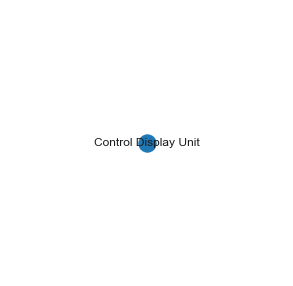

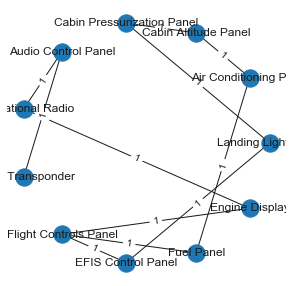

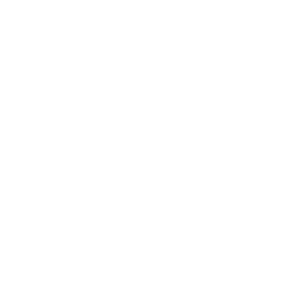

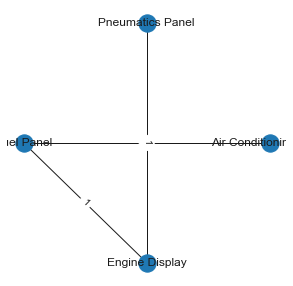

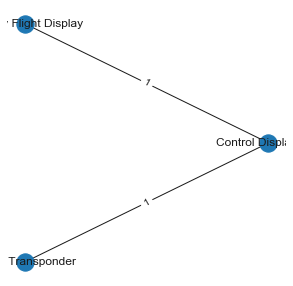

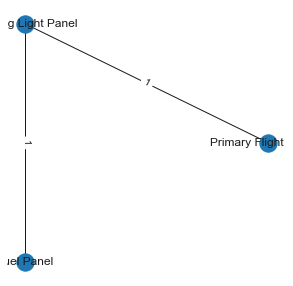

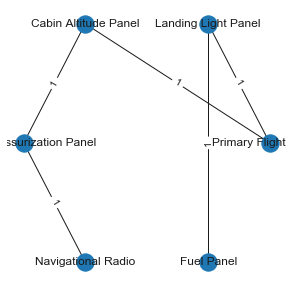

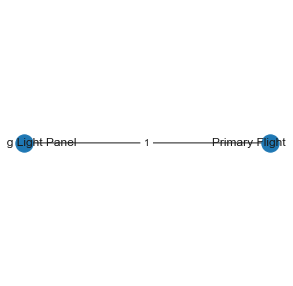

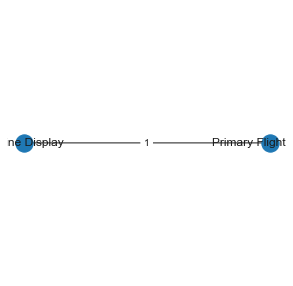

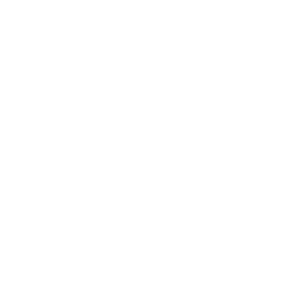

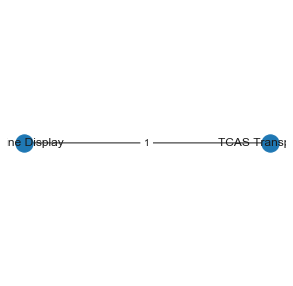

In [33]:
## Drawing them undirected but more detailed - one diagram for each phase
## This time the nodes which are connected are in sequence according to procedural use
ds = dropProdCol(ds)
drawDetailedUndirectedGraphs(ds)

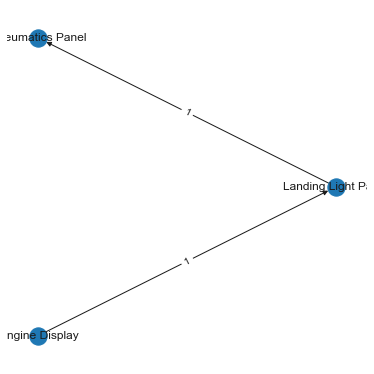

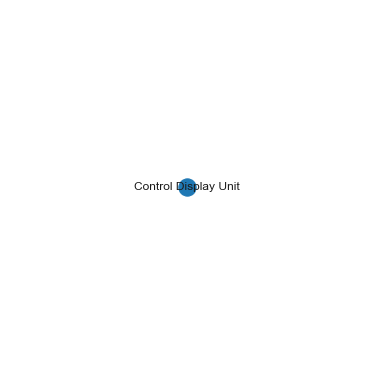

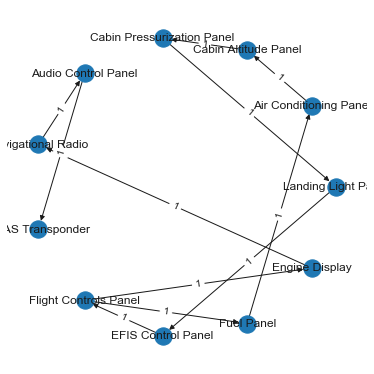

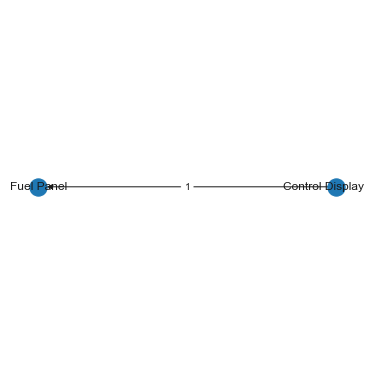

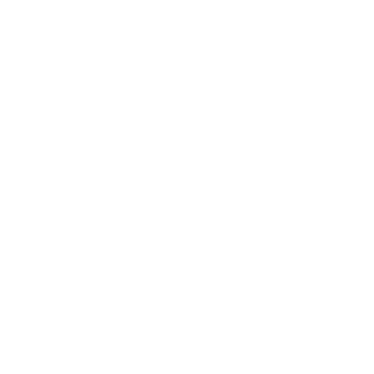

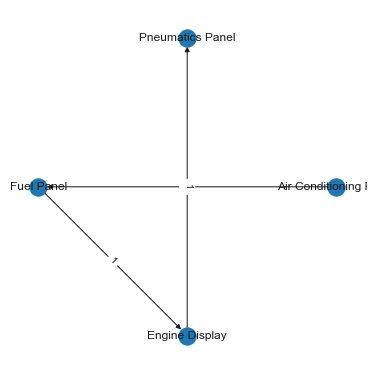

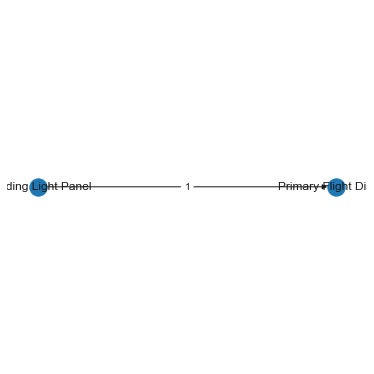

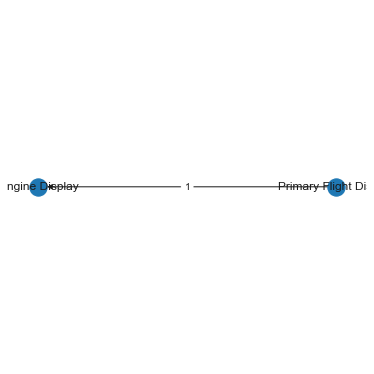

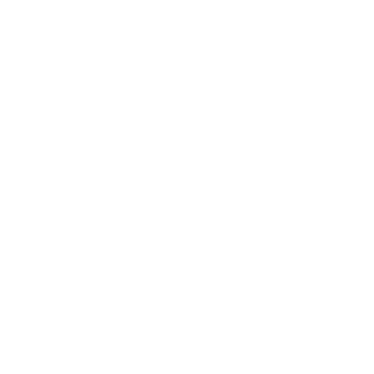

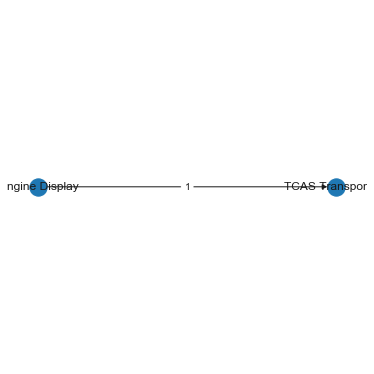

In [34]:
## Drawing them directed but more detailed - one diagram for each phase
## This time the nodes which are connected are in sequence according to procedural use
ds = dropProdCol(ds)
drawDetailedDirectedGraphs(ds)

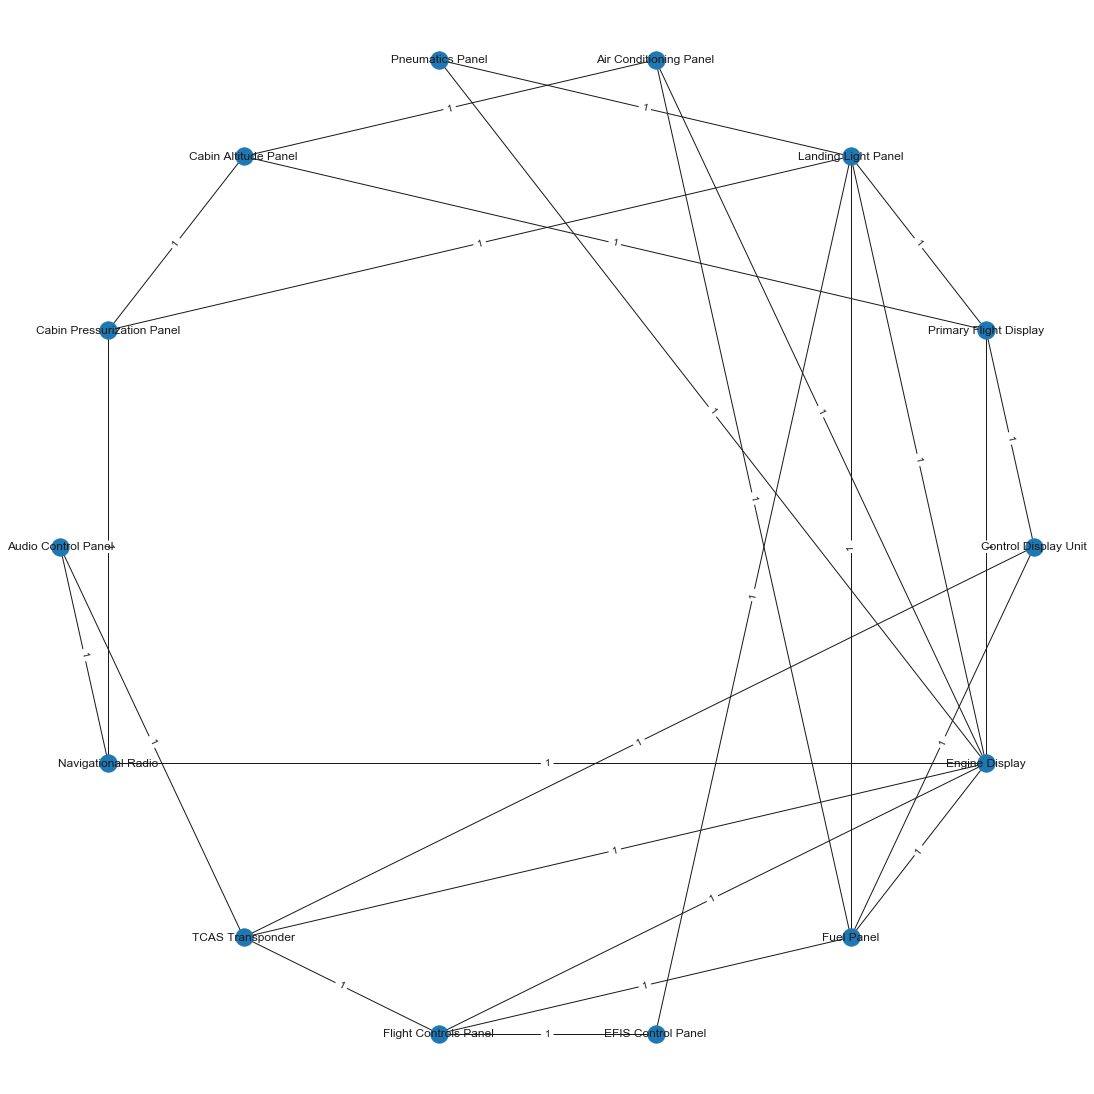

In [35]:
## Drawing full undirected graph - one large diagram
## ALl nodes are connected according to sequence only
ds = dropProdCol(ds)
drawFullDetailedUndirectedGraphs(ds)

In [36]:
## Drawing full directed graph - one large diagram
## ALl nodes are connected according to sequence only
ds = dropProdCol(ds)
drawFullDetailedDirectedGraphs(ds)

In [37]:
def entireGraph_Undirected(dataFrame):
    counter = 1
    lastUsed = 0
    tempGraph = nx.Graph()
    tempGraph.add_nodes_from(dataFrame.columns)
    for index in dataFrame.index.values:
        frames = dataFrame.iloc[index]
        frames = frames.drop_duplicates(keep=False)
        size = getSize(frames)
        for i in range(1, size+1):
            iterator = frames[frames == counter].index.values
            if len(iterator) == 0:
                res = findIndexUsingNum(frames, counter)
                if counter != 1:
                    tempGraph.add_edge(lastUsed, res, weight=1)
                lastUsed = res
                counter +=1
            else:
                if counter != 1:
                    tempGraph.add_edge(lastUsed, iterator[0], weight=1)
                lastUsed = iterator[0]
                counter +=1
    plt.rcParams['figure.figsize'] = [15, 15]
    nx.draw_circular(tempGraph, with_labels=True)
    labels = nx.get_edge_attributes(tempGraph,'weight')
    nx.draw_networkx_edge_labels(tempGraph,pos=nx.circular_layout(tempGraph),edge_labels=labels)
    plt.draw()
    plt.show()

In [38]:
def entireGraph_Directed(dataFrame):
    counter = 1
    lastUsed = 0
    tempGraph = nx.DiGraph()
    tempGraph.add_nodes_from(dataFrame.columns)
    for index in dataFrame.index.values:
        frames = dataFrame.iloc[index]
        frames = frames.drop_duplicates(keep=False)
        size = getSize(frames)
        for i in range(1, size+1):
            iterator = frames[frames == counter].index.values
            if len(iterator) == 0:
                res = findIndexUsingNum(frames, counter)
                if counter != 1:
                    tempGraph.add_edge(lastUsed, res, weight=1)
                lastUsed = res
                counter +=1
            else:
                if counter != 1:
                    tempGraph.add_edge(lastUsed, iterator[0], weight=1)
                lastUsed = iterator[0]
                counter +=1
    plt.rcParams['figure.figsize'] = [15, 15]
    nx.draw_circular(tempGraph, with_labels=True)
    labels = nx.get_edge_attributes(tempGraph,'weight')
    nx.draw_networkx_edge_labels(tempGraph,pos=nx.circular_layout(tempGraph),edge_labels=labels)
    plt.draw()
    plt.show()

In [39]:
## Draw the entire graph with the procedures interconnected
## Undirected
ess = dropProdCol(ess)
entireGraph_Undirected(ess)

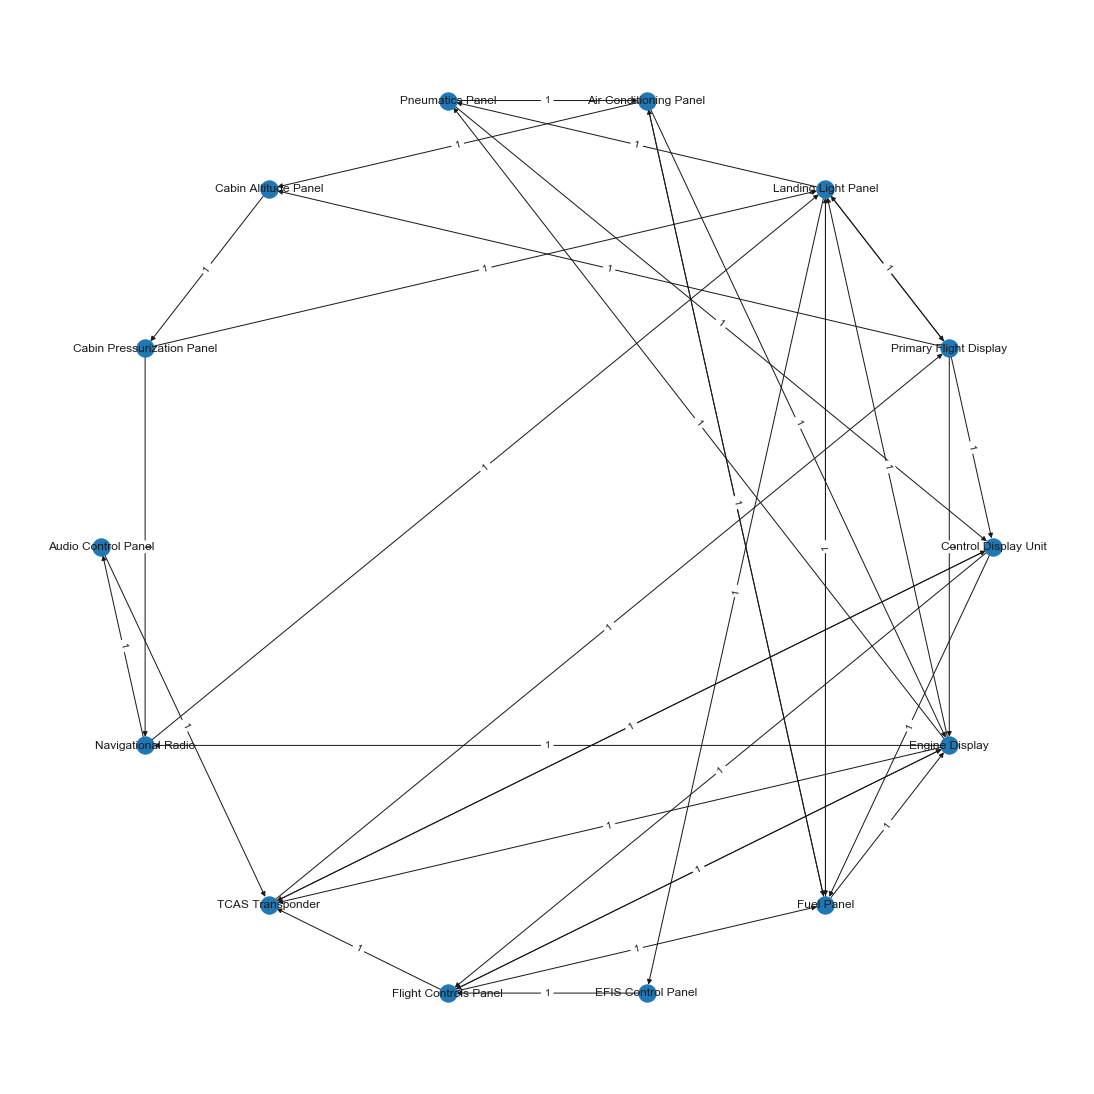

In [40]:
## Draw the entire graph with the procedures interconnected
## Directed
ess = dropProdCol(ess)
entireGraph_Directed(ess)

In [41]:
def graphTransformation(df):
    totals = []
    for col in df.columns.values:
        if(col != 'Quality'):
            totals.append(sum(df[col]))
    transformationGraph = pd.DataFrame(columns=df.columns)
    transformationGraph = transformationGraph.drop(columns=['Quality'])
    ## New list of names
    newNameList = []
    for colName in transformationGraph.columns.values:
        newNameList.append(colName+'_2')
    transformationGraph.columns = newNameList
    tot = pd.Series(totals, index=transformationGraph.columns)
    transformationGraph = transformationGraph.append(tot, ignore_index=True)
    return transformationGraph

In [42]:
def entireGraph_Directed_withWeights(dataFrame, transformationDf):
    counter = 1
    lastUsed = 0
    transDataFrame = graphTransformation(transformationDf)
    tempGraph = nx.DiGraph()
    nodeList = dataFrame.columns.values.tolist()+transDataFrame.columns.values.tolist()
    nodeList.sort()
    tempGraph.add_nodes_from(nodeList)
    ## tying them together
    for col in dataFrame.columns:
        tempGraph.add_edge(col, col+'_2', weight=transDataFrame.iloc[0][col+'_2'])
    for index in dataFrame.index.values:
        frames = dataFrame.iloc[index]
        frames = frames.drop_duplicates(keep=False)
        size = getSize(frames)
        for i in range(1, size+1):
            iterator = frames[frames == counter].index.values
            if len(iterator) == 0:
                res = findIndexUsingNum(frames, counter)
                if counter != 1:
                    if res != lastUsed:
                        tempGraph.add_edge(lastUsed+'_2', res, weight=1)
                lastUsed = res
                counter +=1
            else:
                if counter != 1:
                    if iterator[0] != lastUsed:
                        tempGraph.add_edge(lastUsed+'_2', iterator[0], weight=1)
                lastUsed = iterator[0]
                counter +=1
    plt.rcParams['figure.figsize'] = [15, 15]
    nx.draw_circular(tempGraph, with_labels=True)
    labels = nx.get_edge_attributes(tempGraph,'weight')
    nx.draw_networkx_edge_labels(tempGraph,pos=nx.circular_layout(tempGraph),edge_labels=labels)
    plt.draw()
    plt.show()
    return tempGraph

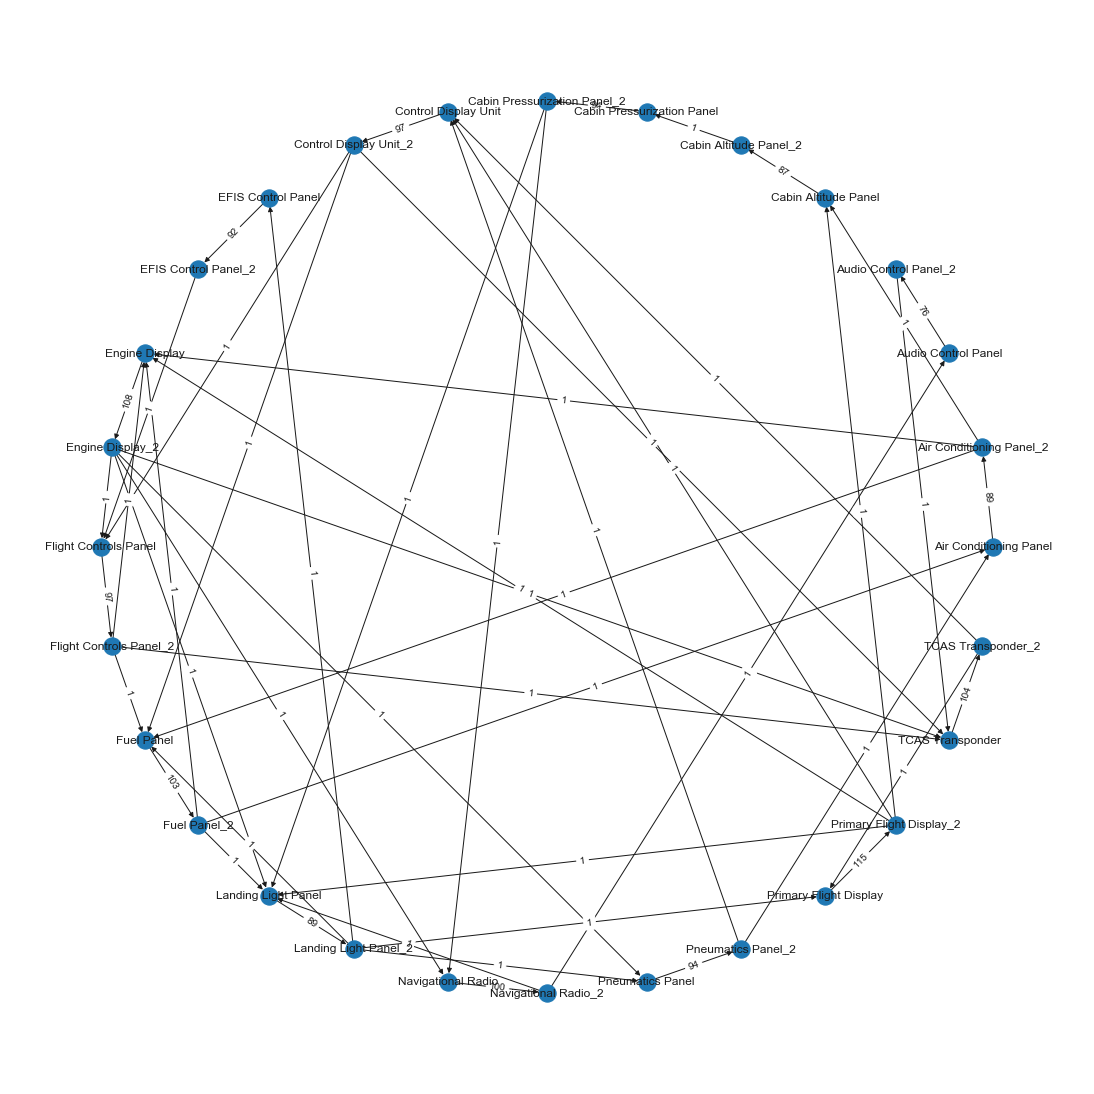

In [43]:
## Draw the entire graph with the procedures interconnected
## Directed
ess = dropProdCol(ess)
fullGraph_Directed_withWeights = entireGraph_Directed_withWeights(ess, df)

In [44]:
def drawFullDetailedDirectedGraphs_withWeights(dataFrame, transformationDf):
    counter = 1
    lastUsed = 0
    transDataFrame = graphTransformation(transformationDf)
    tempGraph = nx.DiGraph()
    nodeList = dataFrame.columns.values.tolist()+transDataFrame.columns.values.tolist()
    nodeList.sort()
    tempGraph.add_nodes_from(nodeList)
    ## tying them together
    for col in dataFrame.columns:
        tempGraph.add_edge(col, col+'_2', weight=transDataFrame.iloc[0][col+'_2'])
    for index in dataFrame.index.values:
        frames = dataFrame.iloc[index]
        frames = frames.drop_duplicates(keep=False)
        size = getSize(frames)
        lastUsed = getFirst(frames)
        for i in range(1, size+1):
            iterator = frames[frames == i].index.values
            if len(iterator) == 0:
                res = findIndexUsingNum(frames, i)
                if counter != 1:
                    if res != lastUsed:
                        tempGraph.add_edge(lastUsed+'_2', res, weight=1)
                lastUsed = res
                counter +=1
            else:
                if counter != 1:
                    if iterator[0] != lastUsed:
                        tempGraph.add_edge(lastUsed+'_2', iterator[0], weight=1)
                lastUsed = iterator[0]
                counter +=1
    plt.rcParams['figure.figsize'] = [15, 15]
    nx.draw_circular(tempGraph, with_labels=True)
    labels = nx.get_edge_attributes(tempGraph,'weight')
    nx.draw_networkx_edge_labels(tempGraph,pos=nx.circular_layout(tempGraph),edge_labels=labels)
    plt.draw()
    plt.show()
    return tempGraph

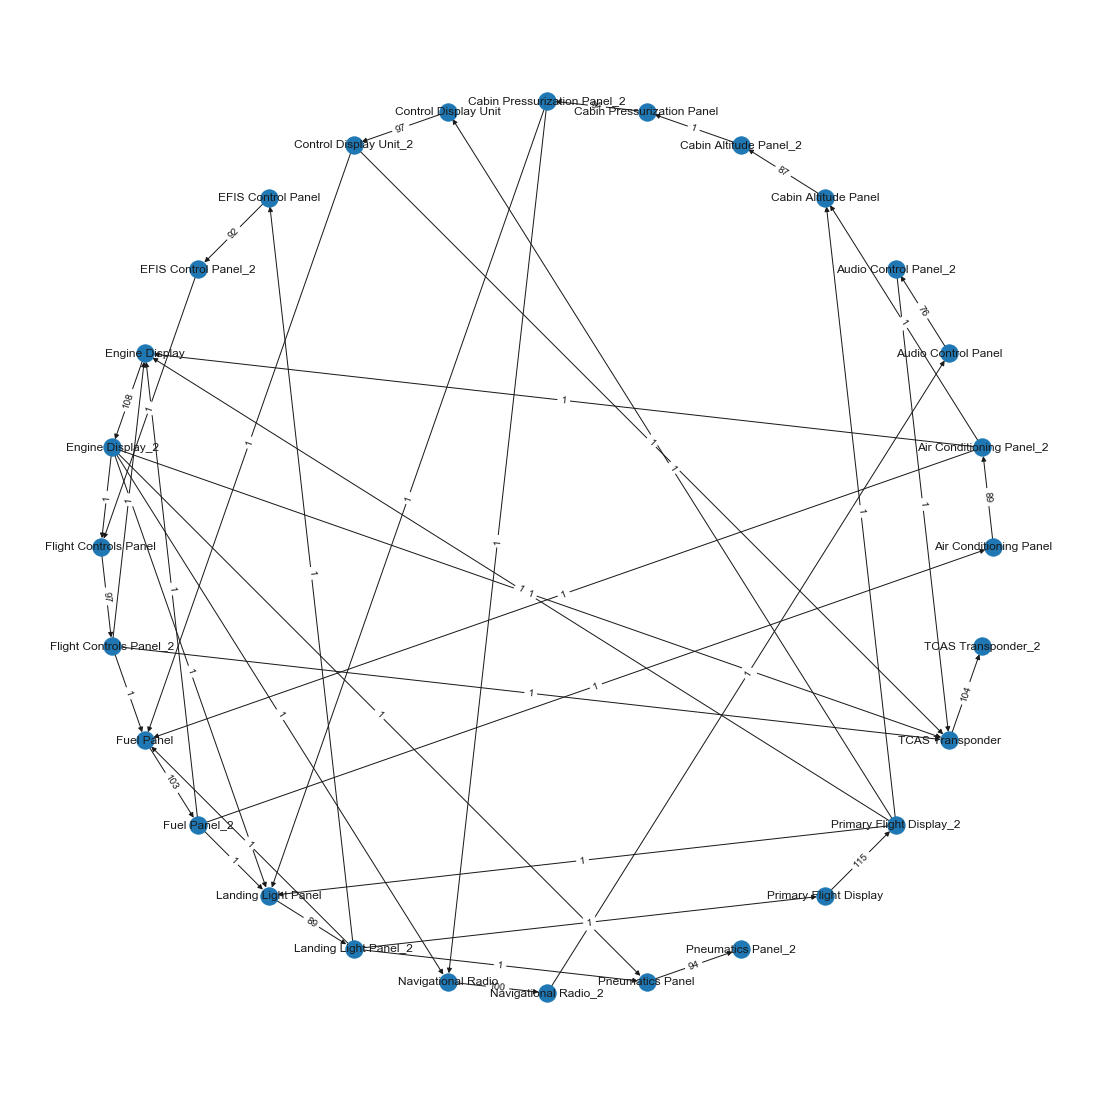

In [45]:
## Drawing full directed graph with weights- one large diagram
## ALl nodes are connected according to sequence only
ds = dropProdCol(ds)
procedureOnly_DirectedGraph_Full_Weighted = drawFullDetailedDirectedGraphs_withWeights(ds, df)

In [46]:
def getCleanList_Tuple(dirtyTupleList):
    cleanList = []
    for item in dirtyTupleList:
        (val1, val2) = item
        if "2" not in val1 and val1 not in cleanList:
            cleanList.append(val1)
        if "2" not in val2 and val2 not in cleanList:
            cleanList.append(val2)
    return cleanList

In [47]:
## Depth First search on procedural only, directed graph, full
dfs_tree_procedureOnly_DirectedGraph_Full_Weighted = nx.dfs_edges(procedureOnly_DirectedGraph_Full_Weighted, source='Engine Display')
clean_dfs_list_procedureOnly_DirectedGraph_Full_Weighted = getCleanList_Tuple(list(dfs_tree_procedureOnly_DirectedGraph_Full_Weighted))

In [48]:
## Breath First search on procedural only, directed graph, full
bfs_tree_procedureOnly_DirectedGraph_Full_Weighted = nx.bfs_edges(procedureOnly_DirectedGraph_Full_Weighted, source='Engine Display')
clean_bfs_list_procedureOnly_DirectedGraph_Full_Weighted = getCleanList_Tuple(list(bfs_tree_procedureOnly_DirectedGraph_Full_Weighted))

In [49]:
## Depth First search on start to finish, directed graph, full
dfs_tree_fullGraph_Directed_withWeights = nx.dfs_edges(fullGraph_Directed_withWeights)
clean_dfs_list_fullGraph_Directed_withWeights = getCleanList_Tuple(list(dfs_tree_fullGraph_Directed_withWeights))

In [50]:
## Breath First search on start to finish, directed graph, full
bfs_tree_fullGraph_Directed_withWeights = nx.dfs_edges(fullGraph_Directed_withWeights, source='Engine Display')
clean_bfs_list_fullGraph_Directed_withWeights = getCleanList_Tuple(list(bfs_tree_fullGraph_Directed_withWeights))

In [51]:
## Creating pandas dataframe: 1 row for each insturment with the following parameters;
# Name,TotalAttributes,ProceduralUse,Height,Width
# 4 columns added later for points AboveRight,AboveLeft,UnderRight,UnderLeft
def dataFrameCreation(pd, df):
    instFrame = pd.DataFrame(columns=['Name', 'TotalAttributes',
                                      'ProceduralUse', 'Height',
                                      'Width', 'AboveRight',
                                      'AboveLeft','UnderRight',
                                      'UnderLeft', 'Colour'])
    columnList = df.columns.values.tolist()
    columnList.remove('Quality')
    for inst in columnList:
        instFrame = instFrame.append({'Name': inst, 'TotalAttributes': df[inst].sum(),
                                      'ProceduralUse': pf[inst].sum(),
                                      'Height':ss.loc[ss.Instrument == inst]['Height'].values[0],
                                      'Width' :ss.loc[ss.Instrument == inst]['Width'].values[0],
                                     'AboveRight': 0,
                                     'AboveLeft': 0,
                                     'UnderRight': 0,
                                     'UnderLeft': 0},
                                     ignore_index=True)

    return instFrame

In [52]:
## Generate Colours
def colGen():
    ## 100 colours
    colourList = []
    for i in range (100):
        colour = (randint(99,255)/255.0,randint(99,255)/255.0,randint(99,255)/255.0)
        while colour not in colourList:
            colour = (randint(99,255)/255.0,randint(99,255)/255.0,randint(99,255)/255.0)
            colourList.append(colour)
    return colourList

In [53]:
## Colour Picker
def colPick(canvas):
    colourList = canvas.getColList()
    picked = random.choice(colourList)
    colourList.remove(picked)
    canvas.setColList(colourList)
    return picked

In [54]:
## Art Canvas ##
class Canvas:
    
    def __init__(self):
        self.colourList = []
        self.paintWidth = 2000
        self.paintHeight = 2000
        self.ims = cairo.ImageSurface(cairo.FORMAT_ARGB32, self.paintWidth, self.paintHeight)
        self.cr = cairo.Context(self.ims)
    
    def getCanvasWidth(self):
        return self.paintWidth
    
    def getCanvasHeight(self):
        return self.paintHeight
    
    def getCr(self):
        return self.cr
    
    def setColList(self, colList):
        self.colourList = colList
        
    def getColList(self):
        return self.colourList

In [55]:
## Co-ordinate checker
def coChecker(bottomLeft, bottomRight, topLeft, topRight, storage):
    #print("Coordinate checker run")
    (bottomLeftX, bottomLeftY) = bottomLeft
    (bottomRightX, bottomRightY) = bottomRight
    (topLeftX, topLeftY) = topLeft
    (topRightX, topRightY) = topRight
    for i in range(topLeftX, topRightX+1):
        for y in range(topRightY, bottomRightY+1):
            if Point(i, y) in storage.getPointList():
                return True
    return False

In [56]:
## North Check
## precursor variable must be a string
def checkNorth(point, width, height, precursorType, storage):
    #print("Checking North")
    (xAxis, yAxis) = point
    if Point(x=xAxis, y=yAxis-1) in storage.getPointList():
        #print("North is not applicable")
        return None
    else:
        dice = random.getrandbits(1)
        newX = xAxis
        newY = yAxis-1
        if(precursorType == 'AboveRight'):
            #print("Precursor is an AboveRight so our point will be a BelowRight")
            ## This means the starting point will be a BelowRight
            bottomRight = Point(newX, newY)
            bottomLeft = Point(newX-width, newY)
            topRight = Point(newX, newY-height)
            topLeft = Point(newX-width, newY-height)
            result = coChecker(bottomLeft, bottomRight, topLeft, topRight, storage)
            if result == False:
                #print("North Precursor success")
                return bottomLeft, bottomRight, topLeft, topRight
            else: 
                #print("North Precursor fail")
                return None
        elif(precursorType == 'AboveLeft'):
            #print("Precursor is an AboveLeft so our point will be a BelowLeft")
            ## This means the starting point will be a BelowLeft
            bottomRight = Point(newX+width,newY)
            bottomLeft = Point(newX, newY)
            topRight = Point(newX+width, newY-height)
            topLeft = Point(newX, newY-height)
            result = coChecker(bottomLeft, bottomRight, topLeft, topRight, storage)
            if result == False:
                #print("North Precursor success")
                return bottomLeft, bottomRight, topLeft, topRight
            else: 
                #print("North Precursor fail")
                return None
        else:
            print("**************************************Complete fail should not happen")
            return None

In [57]:
## South Check
## precursor variable must be a string
def checkSouth(point, width, height, precursorType, storage):
    #print("Checking South")
    (xAxis, yAxis) = point
    if Point(x=xAxis, y=yAxis+1) in storage.getPointList():
        #print("South is not applicable")
        return None
    else:
        newX = xAxis
        newY = yAxis+1
        if(precursorType == 'UnderLeft'):
            #print("Precursor is an UnderLeft so our point will be a AboveLeft")
            ## This means the starting point will be a AboveLeft
            bottomRight = Point(newX+width, newY+height)
            bottomLeft = Point(newX, newY+height)
            topRight = Point(newX+width, newY)
            topLeft = Point(newX, newY)
            result = coChecker(bottomLeft, bottomRight, topLeft, topRight, storage)
            if result == False:
                #print("South Precursor success")
                return bottomLeft, bottomRight, topLeft, topRight
            else: 
                #print("South Precursor fail") 
                return None
        elif(precursorType == 'UnderRight'):
            #print("Precursor is an UnderRight so our point will be a AboveRight")
            ## This means the starting point will be a AboveRight
            bottomRight = Point(newX, newY+height)
            bottomLeft = Point(newX-width, newY+height)
            topRight = Point(newX, newY)
            topLeft = Point(newX-width, newY)
            result = coChecker(bottomLeft, bottomRight, topLeft, topRight, storage)
            if result == False:
                #print("South Precursor success")
                return bottomLeft, bottomRight, topLeft, topRight
            else: 
                #print("South Precursor fail") 
                return None
        else:
            print("**************************************Complete fail should not happen")
            return None

In [58]:
## West Check
## precursor variable must be a string
def checkWest(point, width, height, precursorType, storage):
    #print("Checking East")
    (xAxis, yAxis) = point
    if Point(x=xAxis-1, y=yAxis) in storage.getPointList():
        #print("West is not applicable")
        return None
    else:
        newX = xAxis-1
        newY = yAxis
        if(precursorType == 'UnderLeft'):
            #print("Precursor is an UnderLeft so our point will be a BottomRight")
            ## This means the starting point will be a BottomRight
            bottomRight = Point(newX, newY)
            bottomLeft = Point(newX-width, newY)
            topRight = Point(newX, newY-height)
            topLeft = Point(newX-width, newY-height)
            result = coChecker(bottomLeft, bottomRight, topLeft, topRight, storage)
            if result == False:
                #print("West Precursor success")
                return bottomLeft, bottomRight, topLeft, topRight
            else: 
                #print("West Precursor fail") 
                return None
        elif(precursorType == 'AboveLeft'):
            #print("Precursor is an AboveLeft so our point will be a AboveRight")
            ## This means the starting point will be a AboveRight
            bottomRight = Point(newX, newY+height)
            bottomLeft = Point(newX-width, newY+height)
            topRight = Point(newX, newY)
            topLeft = Point(newX-width, newY)
            result = coChecker(bottomLeft, bottomRight, topLeft, topRight, storage)
            if result == False:
                #print("West Precursor success")
                return bottomLeft, bottomRight, topLeft, topRight
            else: 
                #print("West Precursor fail") 
                return None
        else:
            print("**************************************Complete fail should not happen")
            return None

In [59]:
## East Check
## precursor variable must be a string
def checkEast(point, width, height, precursorType, storage):
    #print("Checking West")
    (xAxis, yAxis) = point
    if Point(x=xAxis+1, y=yAxis) in storage.getPointList():
        #print("East is not applicable")
        return None
    else:
        newX = xAxis+1
        newY = yAxis
        if(precursorType == 'AboveRight'):
            #print("Precursor is an aboveRight so our point will be a AboveLeft")
            ## This means the starting point will be a AboveLeft
            bottomRight = Point(newX+width, newY+height)
            bottomLeft = Point(newX, newY+height)
            topRight = Point(newX+width, newY)
            topLeft = Point(newX, newY)
            result = coChecker(bottomLeft, bottomRight, topLeft, topRight, storage)
            if result == False:
                #print("East Precursor success")
                return bottomLeft, bottomRight, topLeft, topRight
            else: 
                #print("East Precursor fail") 
                return None
        elif(precursorType == 'UnderRight'):
            #print("Precursor is an UnderRight so our point will be a BottomLeft")
            ## This means the starting point will be a BottomLeft
            bottomRight = Point(newX+width,newY)
            bottomLeft = Point(newX, newY)
            topRight = Point(newX+width, newY-height)
            topLeft = Point(newX, newY-height)
            result = coChecker(bottomLeft, bottomRight, topLeft, topRight, storage)
            if result == False:
                #print("East Precursor success")
                return bottomLeft, bottomRight, topLeft, topRight
            else: 
                #print("East Precursor fail") 
                return None
        else:
            print("**************************************Complete fail should not happen")
            return None

In [60]:
def pointFinder(toPlace, alreadyPlaced, storage):
    #print("PointFinder run")
    ## Order is: NSEW
    ## width and height
    width = toPlace['Width'].values[0]
    height = toPlace['Height'].values[0]
    
    ## Pick Point at random
    randomPoint = [0, 1, 2, 3]
    randomDirection = [0, 1]
    random.shuffle(randomPoint)
    
    ## Access each point randomly
    for i in randomPoint:
        if i == 0:
            #print("PointFinder alreadyPlaced ",alreadyPlaced.index.values[0], " bottom left point of it")
            bottomLeft = alreadyPlaced['UnderLeft'].values[0]
            ## Randomly pick side
            random.shuffle(randomDirection)
            for x in randomDirection:
                if x == 0:
                    ## Check South
                    #print("PointFinder alreadyPlaced ",alreadyPlaced.index.values[0], " bottom left SOUTH CHECK")
                    result = checkSouth(bottomLeft, width, height, 'UnderLeft', storage)
                    if result is not None:
                        #print("PointFinder alreadyPlaced ",alreadyPlaced.index.values[0], " bottom left SOUTH CHECK IS GOOD")
                        return result
                    #else:
                        #print("PointFinder alreadyPlaced ",alreadyPlaced.index.values[0], " bottom left SOUTH CHECK BAD")
                if x == 1:
                    ## Check West
                    #print("PointFinder alreadyPlaced ",alreadyPlaced.index.values[0], " bottom left WEST CHECK")
                    result = checkWest(bottomLeft, width, height, 'UnderLeft', storage)
                    if result is not None:
                        #print("PointFinder alreadyPlaced ",alreadyPlaced.index.values[0], " bottom left WEST CHECK IS GOOD")
                        return result
                    #else:
                        #print("PointFinder alreadyPlaced ",alreadyPlaced.index.values[0], " bottom left WEST CHECK BAD")
        
        if i == 1:
            #print("PointFinder alreadyPlaced ",alreadyPlaced.index.values[0], " bottom right point of it")
            bottomRight = alreadyPlaced['UnderRight'].values[0]
            ## Randomly pick side
            random.shuffle(randomDirection)
            for x in randomDirection:
                if x == 0:
                    ## Check South
                    #print("PointFinder alreadyPlaced ",alreadyPlaced.index.values[0], " bottom right SOUTH CHECK")
                    result = checkSouth(bottomRight, width, height, 'UnderRight', storage)
                    if result is not None:
                        #print("PointFinder alreadyPlaced ",alreadyPlaced.index.values[0], " bottom right SOUTH CHECK IS GOOD")
                        return result
                    #else:
                        #print("PointFinder alreadyPlaced ",alreadyPlaced.index.values[0], " bottom right SOUTH CHECK IS BAD")
                if x == 1:
                    ## Check East
                    #print("PointFinder alreadyPlaced ",alreadyPlaced.index.values[0], " bottom right EAST CHECK")
                    result = checkEast(bottomRight, width, height, 'UnderRight', storage)
                    if result is not None:
                        #print("PointFinder alreadyPlaced ",alreadyPlaced.index.values[0], " bottom right EAST CHECK IS GOOD")
                        return result
                    #else:
                        #print("PointFinder alreadyPlaced ",alreadyPlaced.index.values[0], " bottom right EAST CHECK IS BAD")
        
        if i == 2:
            #print("PointFinder alreadyPlaced ",alreadyPlaced.index.values[0], " top left point of it")
            topLeft = alreadyPlaced['AboveLeft'].values[0]
            ## Randomly pick side
            random.shuffle(randomDirection)
            for x in randomDirection:
                if x == 0:
                    ## Check North
                    #print("PointFinder alreadyPlaced ",alreadyPlaced.index.values[0], " top left point NORTH CHECK")
                    result = checkNorth(topLeft, width, height, 'AboveLeft', storage)
                    if result is not None:
                        #print("PointFinder alreadyPlaced ",alreadyPlaced.index.values[0], " top left NORTH CHECK GOOD")
                        return result
                    #else:
                        #print("PointFinder alreadyPlaced ",alreadyPlaced.index.values[0], " top left NORTH CHECK IS BAD")
                if x == 1:
                    ## Check West
                    #print("PointFinder alreadyPlaced ",alreadyPlaced.index.values[0], " top left point WEST CHECK")
                    result = checkWest(topLeft, width, height, 'AboveLeft', storage)
                    if result is not None:
                        #print("PointFinder alreadyPlaced ",alreadyPlaced.index.values[0], " top left WEST CHECK IS GOOD")
                        return result
                    #else:
                        #print("PointFinder alreadyPlaced ",alreadyPlaced.index.values[0], " top left WEST CHECK IS BAD")

        if i == 3:
            #print("PointFinder alreadyPlaced ",alreadyPlaced.index.values[0], " top right point of it")
            topRight = alreadyPlaced['AboveRight'].values[0]
            ## Randomly pick side
            random.shuffle(randomDirection)
            for x in randomDirection:
                if x == 0:
                    ## Check North
                    #print("PointFinder alreadyPlaced ",alreadyPlaced.index.values[0], " top right NORTH CHECK")
                    result = checkNorth(topRight, width, height, 'AboveRight', storage)
                    if result is not None:
                        #print("PointFinder alreadyPlaced ",alreadyPlaced.index.values[0], " top right NORTH CHECK IS GOOD")
                        return result
                    #else:
                        #print("PointFinder alreadyPlaced ",alreadyPlaced.index.values[0], " top right NORTH CHECK IS BAD")
                if x == 1:
                    ## Check East
                    #print("PointFinder alreadyPlaced ",alreadyPlaced.index.values[0], " top right EAST CHECK")
                    result = checkEast(topRight, width, height, 'AboveRight', storage)
                    if result is not None:
                        #print("PointFinder alreadyPlaced ",alreadyPlaced.index.values[0], " top right EAST CHECK IS GOOD")
                        return result
                    #else:
                        #print("PointFinder alreadyPlaced ",alreadyPlaced.index.values[0], " top right EAST CHECK IS BAD")
    
    #print("This instrument's sides are all used up ",alreadyPlaced.index.values[0])

In [61]:
# Iterate through the list and perfom the placement checks
def findMeAPoint(instrument, originalFrame, storage):
    ## Find me a point for this insturment
    ## It starts cycling through the existing ones
    for index in originalFrame.index:
        #print("Cycling through all instruments to find a starting point. Current: ", index)
        tempFrame = originalFrame.loc[[index]]
        if(tempFrame['AboveRight'].values[0] == 0 and tempFrame['AboveLeft'].values[0] == 0 and 
           tempFrame['UnderRight'].values[0] == 0 and tempFrame['UnderLeft'].values[0] == 0):
            #print("This is all nulls, so it must be the first: ", index)
            #firstToPlace(instrument , originalFrame)
            return
        else:
            ## Check each point and if valid, check direction
            #print("This is not the first insturment, must find point from: ", index, " for ", instrument.index.values[0])
            result = pointFinder(instrument,tempFrame, storage)
            if result is not None:
                return result
            #print("THE FOR LOOP FOR FIND ME A POINT GOES ON")
    print("*********************************************************POINT NOT FOUND == SHOULD NOT OCCUR")

In [62]:
# Instrument and draw it
def drawThis(indexNumber, originalFrame, canvas, storage):
    ## Take width and height
    tempFrame = originalFrame.loc[[indexNumber]]
    ## Call method to find the point which can be used
    result = findMeAPoint(tempFrame, originalFrame, storage)
    if result == None:
        ## it was the first point
        modifiedFrame = artist(tempFrame, None, originalFrame, True, canvas, storage)
        return modifiedFrame
    else:
        modifiedFrame = artist(tempFrame, result, originalFrame, False, canvas, storage)
        return modifiedFrame

In [63]:
class Store():
       
    def __init__(self):
        self.PointListCovered = set()
    
    def getPointList(self):
        return self.PointListCovered
    
    def setPointList(self, newList):
        self.PointListCovered = newList

In [64]:
## Store all points used and save
def pointStorage(bottomLeft, bottomRight, topLeft, topRight, storage):
    PointListCovered = storage.getPointList()
    (bottomLeftX, bottomLeftY) = bottomLeft
    (bottomRightX, bottomRightY) = bottomRight
    (topLeftX, topLeftY) = topLeft
    (topRightX, topRightY) = topRight
    for i in range(topLeftX, topRightX+1):
        for y in range(topRightY, bottomRightY+1):
            PointListCovered.add(Point(i, y))
    storage.setPointList(PointListCovered)

In [65]:
def artist(instrument, toDraw, instFrame, first, canvas, storage):
    #print("CALLED TO DRAW: ", instrument.index.values[0])
    cr = canvas.getCr()
    if first == False:
        (bottomLeft, bottomRight, topLeft, topRight) = toDraw
    elif first == True:
        width = instrument['Width'].values[0]
        height = instrument['Height'].values[0]
        xAxis = math.floor(canvas.getCanvasWidth()/2)
        yAxis = math.floor(canvas.getCanvasHeight()/2)
        topLeft = Point(xAxis,yAxis)
        bottomLeft = Point(xAxis,yAxis+height)
        bottomRight = Point(xAxis+width,yAxis+height)
        topRight = Point(xAxis+width,yAxis)
 
    
    ## Store the coordinates in the pandas dataframe original
    instFrame.at[instrument.index.values[0], 'UnderLeft'] = bottomLeft
    instFrame.at[instrument.index.values[0], 'UnderRight'] = bottomRight
    instFrame.at[instrument.index.values[0], 'AboveLeft'] = topLeft
    instFrame.at[instrument.index.values[0], 'AboveRight'] = topRight
    ## Store the tuples to be covered
    pointStorage(bottomLeft, bottomRight, topLeft, topRight, storage)
    ## Now to draw
    (x1,y1) = bottomLeft
    (x2,y2) = bottomRight
    (x3,y3) = topLeft
    (x4,y4) = topRight
    
    cr.move_to(x1,y1)
    cr.line_to(x2,y2)
    cr.line_to(x4,y4)
    cr.line_to(x3,y3)
    cr.line_to(x1,y1)
    cr.close_path()
    
    if instrument['Colour'].isnull().values:
        (r,g,b) = colPick(canvas)
        instFrame.at[instrument.index.values[0], 'Colour'] = (r,g,b)
    else:
        (r,g,b) = instrument['Colour'].values[0]
    cr.set_source_rgb(r,g,b)
    cr.fill_preserve()
    cr.stroke()
    return instFrame

In [66]:
## Method to reset coordinates for redrawn
def resetCO(instFrame):
    for index in instFrame.index:
        instFrame.at[index, 'UnderLeft'] = 0
        instFrame.at[index, 'UnderRight'] = 0
        instFrame.at[index, 'AboveLeft'] = 0
        instFrame.at[index, 'AboveRight'] = 0
    return instFrame

In [67]:
## Legend Artist
def legendDraw(instFrame):
    ## Create canvas
    ims = cairo.ImageSurface(cairo.FORMAT_ARGB32, 2000, 2000)
    cr = cairo.Context(ims)
    x1 = 1000
    y1 = 500
    x2 = 1200
    x3 = 1250
    for index in instFrame.index:
        tempFrame = instFrame.loc[[index]]
        (r,g,b) = tempFrame['Colour'].values[0]
        cr.set_source_rgb(r,g,b)
        cr.move_to(x1,y1)
        cr.line_to(x2,y1)
        cr.set_line_width(19)
        cr.stroke()
        cr.move_to(x3,y1)
        cr.set_source_rgb(0, 0, 0)
        cr.set_font_size(25)
        cr.select_font_face("Arial",
                     cairo.FONT_SLANT_NORMAL,
                     cairo.FONT_WEIGHT_BOLD)
        cr.show_text(tempFrame.Name.values[0])
        y1 = y1 + 100
    ims.write_to_png('Legend.png')

In [68]:
## Main Method Algorithm ##
instFrame = dataFrameCreation(pd, df)
instFrame = instFrame.sort_values(by=['ProceduralUse'], ascending=False)
for x in range(20):
    canvas = Canvas()
    storage = Store()
    canvas.setColList(colGen())
    instFrame = resetCO(instFrame)
    for index in instFrame.index:
        ## Call method which is to take the instrument and draw it
        #print("Main method - Instrument picked to draw: ", index)
        modifiedFrame = drawThis(index, instFrame, canvas, storage)
        instFrame = modifiedFrame
    canvas.ims.write_to_png('Normal_Procedural_'+str(x)+'.png')
legendDraw(instFrame)

In [69]:
## Sorted - full directed graph from procedure only BFS version
instFrame['Name'] = pd.Categorical(instFrame['Name'], clean_bfs_list_procedureOnly_DirectedGraph_Full_Weighted)
instFrame = instFrame.sort_values('Name')
for x in range(20):
    canvas = Canvas()
    storage = Store()
    canvas.setColList(colGen())
    instFrame = resetCO(instFrame)
    for index in instFrame.index:
        ## Call method which is to take the instrument and draw it
        #print("Main method - Instrument picked to draw: ", index)
        modifiedFrame = drawThis(index, instFrame, canvas, storage)
        instFrame = modifiedFrame
    canvas.ims.write_to_png('Procedural_Full_Weighted_BFS_'+str(x)+'.png')
legendDraw(instFrame)

In [70]:
## Sorted - full directed graph from procedure only DFS version
instFrame['Name'] = pd.Categorical(instFrame['Name'], clean_dfs_list_procedureOnly_DirectedGraph_Full_Weighted)
instFrame = instFrame.sort_values('Name')
for x in range(20):
    canvas = Canvas()
    storage = Store()
    canvas.setColList(colGen())
    instFrame = resetCO(instFrame)
    for index in instFrame.index:
        ## Call method which is to take the instrument and draw it
        #print("Main method - Instrument picked to draw: ", index)
        modifiedFrame = drawThis(index, instFrame, canvas, storage)
        instFrame = modifiedFrame
    canvas.ims.write_to_png('Procedural_Weighted_DFS_'+str(x)+'.png')
legendDraw(instFrame)

In [71]:
## Sorted - full directed graph from start to finish BFS version
instFrame['Name'] = pd.Categorical(instFrame['Name'], clean_bfs_list_fullGraph_Directed_withWeights)
instFrame = instFrame.sort_values('Name')
for x in range(20):
    canvas = Canvas()
    storage = Store()
    canvas.setColList(colGen())
    instFrame = resetCO(instFrame)
    for index in instFrame.index:
        ## Call method which is to take the instrument and draw it
        #print("Main method - Instrument picked to draw: ", index)
        modifiedFrame = drawThis(index, instFrame, canvas, storage)
        instFrame = modifiedFrame
    canvas.ims.write_to_png('SF_Full_Weighted_BFS_'+str(x)+'.png')
legendDraw(instFrame)

In [72]:
## Sorted - full directed graph from start to finish DFS version
instFrame['Name'] = pd.Categorical(instFrame['Name'], clean_dfs_list_fullGraph_Directed_withWeights)
instFrame = instFrame.sort_values('Name')
for x in range(20):
    canvas = Canvas()
    storage = Store()
    canvas.setColList(colGen())
    instFrame = resetCO(instFrame)
    for index in instFrame.index:
        ## Call method which is to take the instrument and draw it
        #print("Main method - Instrument picked to draw: ", index)
        modifiedFrame = drawThis(index, instFrame, canvas, storage)
        instFrame = modifiedFrame
    canvas.ims.write_to_png('SF_Full_Weighted_DFS_'+str(x)+'.png')
legendDraw(instFrame)